In [1]:
%pylab inline

from __future__ import division
from time import strftime
from calendar import monthrange
from datetime import datetime, date, timedelta
print strftime('%Y-%m-%d %X'), 'clock set'
import random
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, scale
from sklearn import svm, linear_model, neighbors
from sklearn.grid_search import GridSearchCV

Populating the interactive namespace from numpy and matplotlib
2015-05-30 02:26:18 clock set


In [2]:
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
train = pd.read_csv('../input/train.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Species', 'Latitude', 'Longitude', 'WnvPresent']]
train['Week'] = map(lambda x: x.week, train['Date'])
print train.shape

(10506, 6)


In [3]:
weather = pd.read_csv('../input/weather.csv', na_values={'Tavg': 'M'}, parse_dates=['Date'], date_parser=date_parser)[['Date', 'Station', 'Tmax', 'Tmin', 'Tavg']]

In [4]:
weatherDates = weather.groupby('Date')['Tmax', 'Tavg'].mean().reset_index()

In [5]:
weatherDates['3avg'] = pd.rolling_mean(weatherDates['Tavg'], 3)
weatherDates['7avg'] = pd.rolling_mean(weatherDates['Tavg'], 7)
weatherDates['14avg'] = pd.rolling_mean(weatherDates['Tavg'], 14)
keepDates = map(lambda x: x.month != 5 or x.day >= 14, weatherDates['Date'])
weatherDates = weatherDates[keepDates]

In [6]:
weatherTrain = pd.merge(train, weatherDates, how='left', on=['Date'])

In [7]:
weatherTrain['AntiWeek'] = weatherTrain['Week'] * (52 - weatherTrain['Week'])
weatherTrain['Area'] = scale(weatherTrain['Latitude'] * weatherTrain['Longitude'])

In [8]:
# does this matter? not checked yet
weatherTrain['Latitude'] = scale(weatherTrain['Latitude'])
weatherTrain['Longitude'] = scale(weatherTrain['Longitude'])
weatherTrain['Tmax'] = scale(map(float, weatherTrain['Tmax']))
weatherTrain['Tavg'] = scale(map(float, weatherTrain['Tavg']))
weatherTrain['3avg'] = scale(map(float, weatherTrain['3avg']))
weatherTrain['7avg'] = scale(map(float, weatherTrain['7avg']))
weatherTrain['14avg'] = scale(map(float, weatherTrain['14avg']))
weatherTrain['Week'] = scale(map(float, weatherTrain['Week']))
weatherTrain['Area'] = scale(map(float, weatherTrain['Area']))
weatherTrain['AntiWeek'] = scale(map(float, weatherTrain['AntiWeek']))



In [9]:
mask = np.random.rand(len(weatherTrain)) < 2
trainMini = weatherTrain[mask]
print len(trainMini)

10506


In [10]:
clf = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # try scoring='roc_auc'
clf.fit(trainMini[['Week', 'AntiWeek', 'Latitude', 'Longitude', 'Area', 'Tavg', 'Tmax', '3avg', '7avg', '14avg']], trainMini['WnvPresent'])

RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, gcv_mode=None,
    loss_func=None, normalize=False, score_func=None, scoring=None,
    store_cv_values=False)

In [11]:
Z = clf.predict(trainMini[['Week', 'AntiWeek', 'Latitude', 'Longitude', 'Area', 'Tavg', 'Tmax', '3avg', '7avg', '14avg']])

0.76202976917


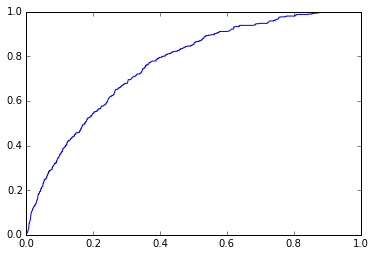

In [12]:
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
fpr, tpr, thresholds = roc_curve(trainMini['WnvPresent'], Z)
print auc(fpr, tpr)
plt.plot(fpr, tpr)

In [13]:
print strftime('%Y-%m-%d %X'), 'clock set'
test = pd.read_csv('../input/test.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Species', 'Latitude', 'Longitude']]
test['Week'] = map(lambda x: x.week, test['Date'])
weatherTest = pd.merge(test, weatherDates, how='left', on=['Date'])

2015-05-30 02:26:20 clock set


In [14]:
weatherTest['AntiWeek'] = weatherTest['Week'] * (52 - weatherTest['Week'])
weatherTest['Area'] = scale(weatherTest['Latitude'] * weatherTest['Longitude'])

In [15]:
# does this matter? not checked yet
weatherTest['Latitude'] = scale(weatherTest['Latitude'])
weatherTest['Longitude'] = scale(weatherTest['Longitude'])
weatherTest['Tmax'] = scale(map(float, weatherTest['Tmax']))
weatherTest['Tavg'] = scale(map(float, weatherTest['Tavg']))
weatherTest['3avg'] = scale(map(float, weatherTest['3avg']))
weatherTest['7avg'] = scale(map(float, weatherTest['7avg']))
weatherTest['14avg'] = scale(map(float, weatherTest['14avg']))
weatherTest['Week'] = scale(map(float, weatherTest['Week']))
weatherTest['Area'] = scale(map(float, weatherTest['Area']))
weatherTest['AntiWeek'] = scale(map(float, weatherTest['AntiWeek']))



In [16]:
Z_test = clf.predict(weatherTest[['Week', 'AntiWeek', 'Latitude', 'Longitude', 'Area', 'Tavg', 'Tmax', '3avg', '7avg', '14avg']])

In [17]:
print min(Z_test), max(Z_test)
# these values are not all between 0 and 1

-0.0937323681482 0.148245783399


In [18]:
Z_test = Z_test + 0.1

In [19]:
print min(Z_test), max(Z_test)
# these values are not all between 0 and 1

0.00626763185183 0.248245783399


In [20]:
with open('ridgecv.csv', 'w') as f:
    f.write('Id,WnvPresent\n')
    for i in xrange(1, 116293 + 1):
        f.write(str(i) + ',' + str(Z_test[i - 1]) + '\n')